In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-29 16:01:02.922825: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-29 16:01:09.531278: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-29 16:01:09.546900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-29 16:01:09.546961: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-29 16:01:09.551285: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-29 16:01:09.555495: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
    
pre_data = data[..., -2:-1]
t_star = t_star[-2:]
data = data[..., -2:]
T = t_star.shape[0]    
    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size


In [6]:
data.shape

(2, 100, 100, 2)

In [7]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [8]:
from scipy.optimize import lsq_linear

In [ ]:
'rho_u': 1.95, 'mu_u': 1.0, 'sigma_u': 0.1 
'rho_v': 1.5, 'sigma_v': 0.1,
'kappa_u': 1.0

In [9]:
data.shape

(2, 100, 100, 2)

In [10]:
n = simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
u_obs = data[0, ..., -1].flatten()
v_obs = data[1, ..., -1].flatten()
uxxyy_obs =simulation.Ds[0] * (n/l) * diffusion(simulation.n, data[0, ..., -1]).flatten()
vxxyy_obs =simulation.Ds[1] * (n/l) * diffusion(simulation.n, data[1, ..., -1]).flatten()
u_dt = (data[0, ..., -2] - data[0, ..., -1]).flatten()
v_dt = (data[1, ..., -2] - data[1, ..., -1]).flatten()

In [11]:

f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n, [0]*n, [0]*n],
                   np.c_[[0]*n, [0]*n, [0]*n, -f_obs, [1]*n]))
b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]
params = np.array([simulation.parameters['rho_u'], simulation.parameters['mu_u'], 
                   simulation.parameters['sigma_u'],
                   simulation.parameters['rho_v'], simulation.parameters['sigma_v']])

In [12]:
params

array([1.95, 1.  , 0.1 , 1.5 , 0.1 ])

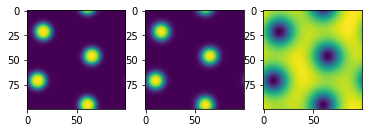

In [13]:
plt.subplot(131)
plt.imshow(f_obs.reshape(100,100))
plt.subplot(132)
plt.imshow(u_obs.reshape(100,100))
plt.subplot(133)
plt.imshow(v_obs.reshape(100,100))
plt.show()

In [14]:
n_s = 4000

In [15]:
np.mean(((np.dot(A_obs[:n_s], params)+b_obs[:n_s]))**2)

1.3226288603014427e-07

In [16]:
np.mean(((np.dot(A_obs[:10000+n_s], params)+b_obs[:10000+n_s]))**2)

9.200543213900651e-08

In [17]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1, -1])
        cost: 133.5797322484867
         fun: array([0.00499141, 0.00499474, 0.00499621, ..., 0.06290806, 0.06302764,
       0.06315791])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.2656542480726785e-14
      status: 2
     success: True
           x: array([1.87417058e-32, 6.00673955e-02, 1.38156625e-02, 4.07637723e-42,
       1.75162308e-46])